# Zadania

In [1]:
# Two-class MNIST 

import os
os.environ['KERAS_BACKEND'] = 'theano'
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt 

d1 = 5
d2 = 6

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

X_train = (mnist_x_train.astype('float32') / 255.).reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
y_train = mnist_y_train
X_test = (mnist_x_test.astype('float32') / 255.).reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
y_test = mnist_y_test

X_train = X_train[np.logical_or(y_train == d1, y_train == d2)]
y_train = y_train[np.logical_or(y_train == d1, y_train == d2)]
y_train[y_train==d1] = 0
y_train[y_train==d2] = 1
y_train = y_train.astype('float32')
X_test = X_test[np.logical_or(y_test == d1, y_test == d2)]
y_test = y_test[np.logical_or(y_test == d1, y_test == d2)]
y_test[y_test==d1] = 0
y_test[y_test==d2] = 1
y_test = y_test.astype('float32')

print (X_train.shape)
print (X_test.shape)


Using Theano backend.


(11339, 784)
(1850, 784)


## Ćwiczenie 1 [5 pkt]

Uzupełnij metody forward_pass oraz backward_pass w klasach ReLU, Sigmoid i Dense. Metoda forward_pass ma przyjmować batch inputów i zwracać batch outputów. Metoda backward_pass ma przyjmować batch inputów oraz batch pochodnych cząstkowych outputów i zwracać batch pochodnych cząstkowych inputów oraz wektor (**nie batch**) pochodnych cząstkowych wag. Jeśli wagi przechowujemy w macierzy dwuwymiarowej, to możemy najpierw policzyć pochodne cząstkowe w macierzy o takim samym kształcie, a następnie np. użyć .flat.

## Ćwiczenie 2 [4 pkt]

Uzupełnij metodę _forward_pass klasy Network. Metoda ta ma przyjmować batch inputów (X) i zwracać dwie rzeczy:
* inps - lista batchów inputów dla każdej warstwy w sieci (włącznie z X); te wartości będziemy używali w metodzie _backward_pass
* output - batch outputów z sieci (czyli $\mathbf{\hat y}$); output **nie** powinien być ostatnim elementem inps.

## Ćwiczenie 3 [5 pkt]

Uzupełnij metodę _backward_pass klasy Network. Zwróć uwagę, że pochodna funkcji kosztu po neuronach ostatniej warstwy jest już liczona w metodzie _fit_on_batch. Metoda ma zwracać listę layer_grads, której elementy to wektory pochodnych cząstkowych funkcji kosztu po kolejnych warstwach (zwrócone przez metodę Layer.backward_pass). Kolejność wektorów w tej liście ma być zgodna z kolejnością warstw w sieci.

## Ćwiczenie 4 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą i aktywacją Sigmoid na powyższych danych (dwuklasowy MNIST). Użyj MSE jako funkcji kosztu (oznacza to regresję do numeru klasy, co jest złym pomysłem, ale póki nie mamy klasy Crossentropy musi nam to wystarczyć). Użyj GD. Reportuj loss oraz accuracy.

## Ćwiczenie 5 [3 pkt]
Uzupełnić klasę Crossentropy, wzorując się na klasie MSE.

## Ćwiczenie  6 [3 pkt]
Uzupełnić klasę Momentum, wzorując się na klasie GD. Wzory można znaleźć tutaj: http://distill.pub/2017/momentum/

## Ćwiczenie 7 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą. Rozważ dwa przypadki: aktywację ReLU oraz Sigmoid. Czy jest sens używać ReLU jako ostatnią warstwę? Użyj Crossentropy jako funkcji kosztu. Użyj Momentum. Reportuj loss oraz accuracy.

## Ćwiczenie 8 [6 pkt]
Vanishing gradient.

Zadanie polega na zbadaniu zjawiska *vanishing gradient* w głębokich sieciach. Należy zmodyfikować kod warstwy Dense i dodać monitorowanie **normy euklidesowej** wektora delta_weights. Każdą warstwę Dense w trenowanej sieci należy monitorować oddzielnie. Po każdym wywołaniu metody fit_on_batch każdy z monitorów powinien zapamiętać nową normę. Po nauczeniu sieci dla każdej warstwy należy narysować wykres: poziomo - numer wywołania fit_on_batch, pionowo - norma delta_weights. Im niżej znajduje się warstwa Dense, tym silniej będzie zachodziło zjawisko *vanishing gradient*.

Naucz dwuwarstwową sieć z aktywacjami Sigmoid, reportując normy delta_weights. Powtórz to dla głębszej sieci (np. 6-10 warstw).

## Ćwiczenie 9 [4 pkt]
Przetestować kod z ćwiczenia 7. (dwuwarstwowa sieć) stosując inne inicjalizacje wag w warstwach Dense. Napisać własną inicjalizację wag, która sprawi, że sieć niczego się nie nauczy (init='stupid').


In [2]:
def sigmoid_function(x):
    return 1 / (1 + np.exp(-x))


def accuracy(pred, t):
    return np.mean(t == np.around(pred))
# Warstwy

class Layer():

    def forward_pass(self, input):
        # return output
        raise NotImplementedError()

    def backward_pass(self, input, output_grad):
        # return input_grad, weight_grad
        raise NotImplementedError()

    def update_weights(self, delta_weights):
        pass

    def debug_grad(self, evaluate_loss):
        return None

class ReLU(Layer):

    def forward_pass(self, input):
        return np.maximum.reduce([input, np.zeros(shape = np.shape(input))])
        
    def backward_pass(self, input, output_grad):
        factor = np.sign(np.maximum.reduce([input, np.zeros(shape = np.shape(input))]))
        return np.multiply(factor, output_grad), None

class Sigmoid(Layer):

    def forward_pass(self, input):
        return sigmoid_function(input)
        

    def backward_pass(self, input, output_grad):
        return np.multiply(np.multiply(output_grad, sigmoid_function(input)), np.ones(shape = np.shape(input)) - sigmoid_function(input)), None

class Dense(Layer):

    def __init__(self, input_size, output_size, init = 'gaussian'):
        self.delta_weights_norms = []
        input_size += 1
        if init == 'zeros':
            self.weights = np.zeros((input_size, output_size))
        elif init == 'gaussian':
            self.weights = np.random.normal(
                0.,
                2. / (input_size + output_size),
                (input_size, output_size)
            )
        elif init == 'stupid':
            # Ćwiczenie 8
            self.weights = 10*np.ones((input_size, output_size))          
        else:
            raise NotImplementedError()
        self.weights = np.asmatrix(self.weights)

    def forward_pass(self, input):
        X = np.hstack((np.ones((input.shape[0],1)),input))
        
        
        return np.dot(X, self.weights)  
    
    def backward_pass(self, input, output_grad):
        
        X = np.hstack((np.ones((input.shape[0],1)),input))
        
        
        weight_grad = np.dot(X.T, output_grad)
        input_grad = np.dot(output_grad, self.weights.T)
        return input_grad[:,1:], weight_grad.flat

    def update_weights(self, delta_weights):
        # Ćwiczenie 7 - monitorowanie normy wektora delta_weights
        self.weights += delta_weights.reshape(self.weights.shape)
        self.delta_weights_norms.append(np.linalg.norm(delta_weights))

    def debug_grad(self, evaluate_loss):
        base = evaluate_loss()
        grad = []
        for (x, y), w in np.ndenumerate(self.weights):
            self.weights[x, y] = w + 0.0001
            changed = evaluate_loss()
            grad.append(10000. * (changed - base))
            self.weights[x, y] = w
        return grad

In [3]:
# Optimizers

class Optimizer():

    def calculate_deltas(self, grad):
        raise NotImplementedError()

class GD(Optimizer):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def calculate_deltas(self, grad):
        return -self.learning_rate * grad

class Momentum(Optimizer):

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.z = 0
        
    def calculate_deltas(self, grad):
        self.z = self.beta * self.z + grad
        return -self.alpha * self.z
        

In [4]:
# Funkcje kosztu

class Loss():

    def forward_pass(self, y, t):
        # return cost
        raise NotImplementedError()

    def backward_pass(self, y, t):
        # return y_grad
        raise NotImplementedError()

class MSE(Loss):

    def forward_pass(self, y, t):
        return np.average(0.5 * np.square(y - t))

    def backward_pass(self, y, t):
        return (y - t) / y.size

class Crossentropy(Loss):

    def forward_pass(self, y, t):
        # Ćwiczenie 5
        return np.average(np.multiply(-t, np.log(y)) - np.multiply(1-t,np.log(1-y)))
        
    def backward_pass(self, y, t):
        # Ćwiczenie 5
        return (-t/y + (1-t)/(1-y))/ y.size


In [5]:
class Network():

    def __init__(self, loss, optimizer, metrics = []):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics

    def add(self, layer):
        self.layers.append(layer)

    def fit(self, X, t, epochs, batch_size=256, print_stats=False):
        X = np.array(X)
        t = np.array(t)
        X = X.reshape(len(X), -1)
        t = t.reshape(len(t), -1)
        if X.shape[0] != t.shape[0]:
            raise ValueError("Array sizes don't match")

        for epoch in range(epochs):
            if print_stats:
                print("Epoch %d" % (epoch+1))
                print("    -> batch size: %d" % batch_size)
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            np.random.set_state(rng_state)
            np.random.shuffle(t)
            pos = 0
            while pos < len(X):
                batch_X = X[pos:pos+batch_size]
                batch_t = t[pos:pos+batch_size]
                self._fit_on_batch(batch_X, batch_t)
                pos += batch_size
            if print_stats:
                _, y = self._forward_pass(X)
                l = self.loss.forward_pass(y, t)
                print("    -> loss: %f" % l)
                for m in self.metrics:
                    print("    -> %s: %f" % (m.__name__, m(y, t)))

    def predict(self, X):
        inps, out = self._forward_pass(X)
        return out

    def _fit_on_batch(self, batch_X, batch_t):
        inps, out = self._forward_pass(batch_X)
        layer_grads = self._backward_pass(
            inps,
            self.loss.backward_pass(out, batch_t)
        )
        grad = self._join(layer_grads)
        deltas = self.optimizer.calculate_deltas(grad)
        for l, d in zip(self.layers, self._split(deltas, layer_grads)):
            if not d is None:
                l.update_weights(d)

    def _join(self, grads):
        return np.concatenate([g for g in grads if not g is None])

    def _split(self, grads, layer_grads):
        out = []
        start = 0
        for l in layer_grads:
            if l is None:
                out.append(None)
            else:
                out.append(grads[start:start+len(l)])
                start += len(l)
        return out

    def _forward_pass(self, X):
        
        inps = [X]
        for layer in self.layers[:-1]:
            inps.append(layer.forward_pass(inps[-1]))
        output = self.layers[-1].forward_pass(inps[-1])
        
        return inps, output
    
    def _backward_pass(self, inps, grad):
        output_grad = grad
        layer_grads = []
        
        for i, layer in enumerate(self.layers[::-1]):
            
            output_grad, new_layer_grad = layer.backward_pass(inps[-(i+1)],output_grad)
            layer_grads.insert(0,new_layer_grad)
            
        return layer_grads

    def _debug_grads(self, X, t):
        layer_grads = []
        for l in self.layers:
            g = l.debug_grad(
                lambda: self.loss.forward_pass(self._forward_pass(X)[1], t)
            )
            if not g is None:
                g = np.array(np.array(g).flat)
            layer_grads.append(g)
        return layer_grads

In [6]:
# Ćwiczenie 4
NN = Network(MSE(), GD(0.1), metrics = [accuracy])
NN.add(Dense(input_size=784, output_size = 1))
NN.add(Sigmoid())

NN.fit(X_train, y_train, 10, batch_size=2560, print_stats=True)

Epoch 1
    -> batch size: 2560
    -> loss: 0.095021
    -> accuracy: 0.904930
Epoch 2
    -> batch size: 2560
    -> loss: 0.076613
    -> accuracy: 0.933945
Epoch 3
    -> batch size: 2560
    -> loss: 0.064710
    -> accuracy: 0.943028
Epoch 4
    -> batch size: 2560
    -> loss: 0.056594
    -> accuracy: 0.946380
Epoch 5
    -> batch size: 2560
    -> loss: 0.050792
    -> accuracy: 0.950260
Epoch 6
    -> batch size: 2560
    -> loss: 0.046425
    -> accuracy: 0.951671
Epoch 7
    -> batch size: 2560
    -> loss: 0.043037
    -> accuracy: 0.952994
Epoch 8
    -> batch size: 2560
    -> loss: 0.040312
    -> accuracy: 0.954317
Epoch 9
    -> batch size: 2560
    -> loss: 0.038062
    -> accuracy: 0.955816
Epoch 10
    -> batch size: 2560
    -> loss: 0.036177
    -> accuracy: 0.956786


In [7]:
# Ćwiczenie 7
#SIGMOID
NN = Network(Crossentropy(), Momentum(alpha = 0.1, beta = 0.1), metrics = [accuracy])
NN.add(Dense(input_size=784, output_size = 1))
NN.add(Sigmoid())

NN.fit(X_train, y_train, 10, batch_size=2560, print_stats=True)

Epoch 1
    -> batch size: 2560
    -> loss: 0.362616
    -> accuracy: 0.940736
Epoch 2
    -> batch size: 2560
    -> loss: 0.268825
    -> accuracy: 0.950084
Epoch 3
    -> batch size: 2560
    -> loss: 0.224724
    -> accuracy: 0.955287
Epoch 4
    -> batch size: 2560
    -> loss: 0.198446
    -> accuracy: 0.958462
Epoch 5
    -> batch size: 2560
    -> loss: 0.180632
    -> accuracy: 0.960843
Epoch 6
    -> batch size: 2560
    -> loss: 0.167648
    -> accuracy: 0.961990
Epoch 7
    -> batch size: 2560
    -> loss: 0.157664
    -> accuracy: 0.962872
Epoch 8
    -> batch size: 2560
    -> loss: 0.149648
    -> accuracy: 0.963930
Epoch 9
    -> batch size: 2560
    -> loss: 0.143180
    -> accuracy: 0.964459
Epoch 10
    -> batch size: 2560
    -> loss: 0.137775
    -> accuracy: 0.965253


In [8]:
# Ćwiczenie 7
#RELU
NN = Network(Crossentropy(), Momentum(alpha = 0.1, beta = 0.1), metrics = [accuracy])
NN.add(Dense(input_size=784, output_size = 1))
NN.add(ReLU())

NN.fit(X_train, y_train, 10, batch_size=2560, print_stats=True)

Epoch 1
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 2
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 3
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 4
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 5
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 6
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 7
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 8
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 9
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000
Epoch 10
    -> batch size: 2560
    -> loss: nan
    -> accuracy: 0.000000


RELU nie jest dobrą aktywacją. Zrzuca ujemne wartości do zera, co powoduje komplikacje przy Crossentropy.

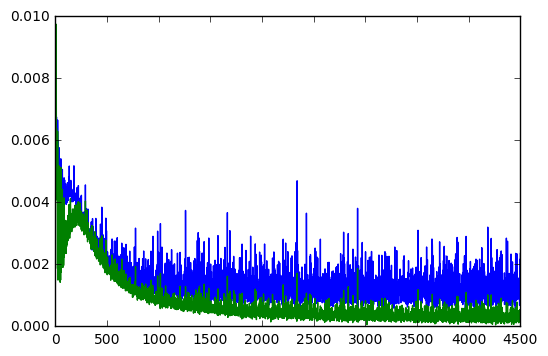

In [9]:
# Ćwiczenie 8
NN = Network(MSE(), GD(0.1), metrics = [accuracy])
NN.add(Dense(input_size=784, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 1))
NN.add(Sigmoid())

NN.fit(X_train, y_train, 100, batch_size=256)

plt.plot(NN.layers[0].delta_weights_norms)
plt.plot(NN.layers[2].delta_weights_norms)
plt.show()

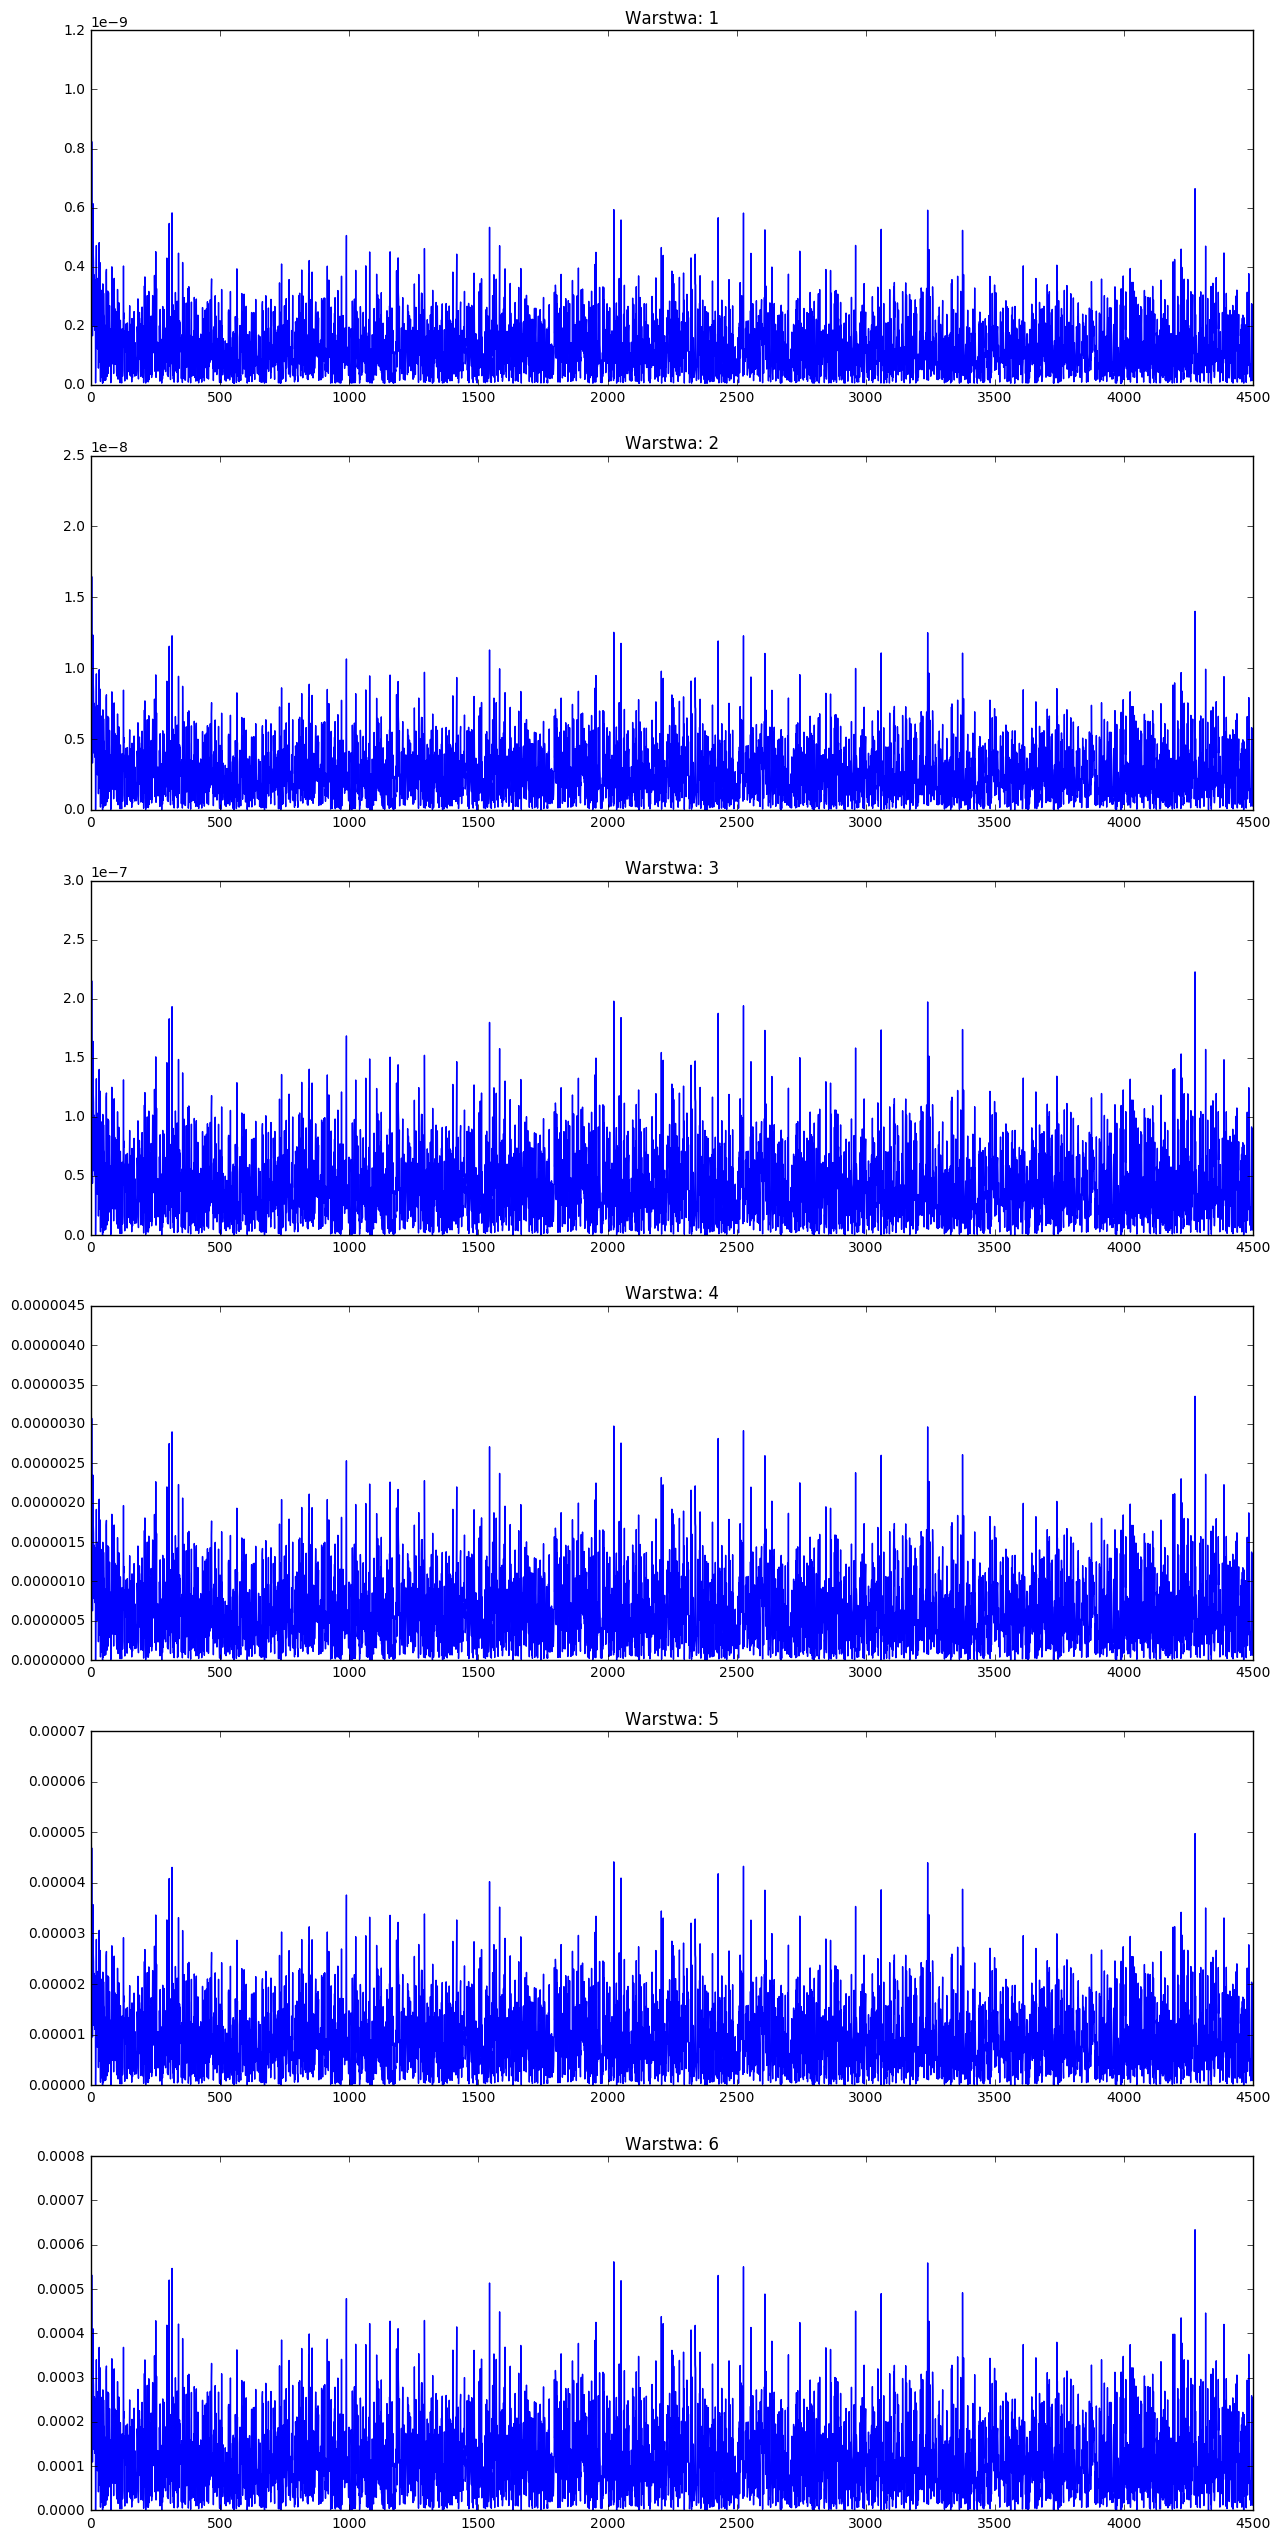

In [10]:
# Ćwiczenie 8
NN = Network(MSE(), GD(0.1), metrics = [accuracy])
NN.add(Dense(input_size=784, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 10))
NN.add(Sigmoid())
NN.add(Dense(input_size=10, output_size = 1))
NN.add(Sigmoid())

NN.fit(X_train, y_train, 100, batch_size=256)

plt.figure(figsize=(15,32))
plt.subplot(6,1,1)
plt.title("Warstwa: 1")
plt.plot(NN.layers[2].delta_weights_norms)
plt.subplot(6,1,2)
plt.title("Warstwa: 2")
plt.plot(NN.layers[4].delta_weights_norms)
plt.subplot(6,1,3)
plt.title("Warstwa: 3")
plt.plot(NN.layers[6].delta_weights_norms)
plt.subplot(6,1,4)
plt.title("Warstwa: 4")
plt.plot(NN.layers[8].delta_weights_norms)
plt.subplot(6,1,5)
plt.title("Warstwa: 5")
plt.plot(NN.layers[10].delta_weights_norms)
plt.subplot(6,1,6)
plt.title("Warstwa: 6")
plt.plot(NN.layers[12].delta_weights_norms)
plt.show()

Jak widać po skali na osi Y, im głębiej znajduje się sięć tym mniejsza norma wektora Delta Weights.

In [11]:
# Ćwiczenie 9
NN = Network(MSE(), GD(0.1), metrics = [accuracy])
NN.add(Dense(input_size=784, output_size = 1, init = "stupid"))
NN.add(Sigmoid())

NN.fit(X_train, y_train, 1, batch_size=2560, print_stats=True)
NN.fit(X_train, y_train, 1000, batch_size=2560)
NN.fit(X_train, y_train, 1, batch_size=2560, print_stats=True)

Epoch 1
    -> batch size: 2560
    -> loss: 0.239042
    -> accuracy: 0.521916
Epoch 1
    -> batch size: 2560
    -> loss: 0.239042
    -> accuracy: 0.521916


Pomimo 1000 epok, sieć nie nauczyła się niczego.


## Ćwiczenie 1

In [12]:
np.random.seed(43)
d1 = Dense(input_size=4, output_size=3, init="gaussian")
d2 = Dense(input_size=4, output_size=3, init="zeros")
r = ReLU()
s = Sigmoid()
inp = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_4 = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_3 = np.random.random(3).reshape((1,-1)) - 0.5

print ("inp:")
print (inp.shape)
print( inp)
print( "out_grad_4:")
print( out_grad_4.shape)
print( out_grad_4)
print( "out_grad_3:")
print( out_grad_3.shape)
print( out_grad_3)

print( "Testing d1...")
print( "d1.forward_pass(inp):")
t = d1.forward_pass(inp)
print( t.shape)
print( t)
print( "d1.backward_pass(inp, out_grad_3):")
t = d1.backward_pass(inp, out_grad_3)
print( t[0].shape)
print( t[0])
print( np.shape(t[1]))
print( list(t[1]))

print( "Testing d2...")
print("d2.forward_pass(inp):")
t = d2.forward_pass(inp)
print( t.shape)
print (t)
print( "d2.backward_pass(inp, out_grad_3):")
t = d2.backward_pass(inp, out_grad_3)
print( t[0].shape)
print( t[0])
print( np.shape(t[1]))
print( list(t[1]))

print( "Testing r...")
print( "r.forward_pass(inp):")
t = r.forward_pass(inp)
print( t.shape)
print(t)
print( "r.backward_pass(inp, out_grad_4):")
t = r.backward_pass(inp, out_grad_4)
print( t[0].shape)
print( t[0])
print( t[1])

print( "Testing s...")
print( "s.forward_pass(inp):")
t = s.forward_pass(inp)
print( t.shape)
print( t)
print( "s.backward_pass(inp, out_grad_4):")
t = s.backward_pass(inp, out_grad_4)
print( t[0].shape)
print( t[0])
print( t[1])

inp:
(1, 4)
[[-0.05424164  0.16972465 -0.41749995  0.39709858]]
out_grad_4:
(1, 4)
[[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
out_grad_3:
(1, 3)
[[-0.02440363  0.13637368  0.47820413]]
Testing d1...
d1.forward_pass(inp):
(1, 3)
[[-0.02707048 -0.20288487 -0.03403094]]
d1.backward_pass(inp, out_grad_3):
(1, 4)
[[-0.01685764  0.21647157  0.04530229  0.03971692]]
(15,)
[-0.024403632992746838, 0.13637367757152263, 0.47820413408200613, 0.0013236930549925055, -0.0073971318097950543, -0.025938576085830872, -0.0041418981104407735, 0.023145974929848781, 0.081163030108997142, 0.010188515561680662, -0.056936003608726853, -0.19965020221385238, -0.0096906480078102902, 0.054153793710511253, 0.18989418258526386]
Testing d2...
d2.forward_pass(inp):
(1, 3)
[[ 0.  0.  0.]]
d2.backward_pass(inp, out_grad_3):
(1, 4)
[[ 0.  0.  0.  0.]]
(15,)
[-0.024403632992746838, 0.13637367757152263, 0.47820413408200613, 0.0013236930549925055, -0.0073971318097950543, -0.025938576085830872, -0.0041418981104407735

    inp:
    (1, 4)
    [[-0.05424164  0.16972465 -0.41749995  0.39709858]]
    out_grad_4:
    (1, 4)
    [[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
    out_grad_3:
    (1, 3)
    [[-0.02440363  0.13637368  0.47820413]]
    Testing d1...
    d1.forward_pass(inp):
    (1, 3)
    [[-0.02707048 -0.20288487 -0.03403094]]
    d1.backward_pass(inp, out_grad_3):
    (1, 4)
    [[-0.01685764  0.21647157  0.04530229  0.03971692]]
    (15,)
    [-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
     -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
     -0.00969065  0.05415379  0.18989418]
    Testing d2...
    d2.forward_pass(inp):
    (1, 3)
    [[ 0.  0.  0.]]
    d2.backward_pass(inp, out_grad_3):
    (1, 4)
    [[ 0.  0.  0.  0.]]
    (15,)
    [-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
     -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
     -0.00969065  0.05415379  0.18989418]
    Testing r...
    r.forward_pass(inp):
    (1, 4)
    [[ 0.          0.16972465  0.          0.39709858]]
    r.backward_pass(inp, out_grad_4):
    (1, 4)
    [[ 0.         -0.23769518  0.          0.04320252]]
    None
    Testing s...
    s.forward_pass(inp):
    (1, 4)
    [[ 0.48644291  0.5423296   0.39711514  0.59799036]]
    s.backward_pass(inp, out_grad_4):
    (1, 4)
    [[-0.050462   -0.05899789 -0.11847926  0.01038579]]
    None

## Ćwiczenie 2

In [13]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=3, output_size=4, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=4, output_size=1, init="gaussian"))
n.add(Sigmoid())
inp = np.random.random((2,4)) - 0.5
inps, out = n._forward_pass(inp)

print ("inp:")
print (inp)
for i, inp in enumerate(inps):
    print ("inps[" + str(i) + "]:")
    print (inp)
print ("out:")
print (out)

inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]


    inp:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[0]:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[1]:
    [[ 0.06231216 -0.25663962 -0.11549112]
     [ 0.03836232 -0.10585852 -0.03015728]]
    inps[2]:
    [[ 0.06231216  0.          0.        ]
     [ 0.03836232  0.          0.        ]]
    inps[3]:
    [[-0.04493685  0.4840028  -0.15711608 -0.22696511]
     [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
    inps[4]:
    [[ 0.          0.4840028   0.          0.        ]
     [ 0.          0.48391873  0.          0.        ]]
    inps[5]:
    [[ 0.29948146]
     [ 0.29947621]]
    out:
    [[ 0.57431575]
     [ 0.57431447]]

## Ćwiczenie 3

In [14]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=3, output_size=4, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=4, output_size=1, init="gaussian"))
n.add(Sigmoid())

inp = np.random.random((2,4)) - 0.5
target = inp[:,0:1]
inps, out = n._forward_pass(inp)
grad = n.loss.backward_pass(out, target)
layer_grads = n._backward_pass(inps, grad)

print ("inp:")
print (inp)
print ("target:")
print (target)
for i, inp in enumerate(inps):
    print ("inps[" + str(i) + "]:")
    print (inp)
print ("out:")
print (out)
print ("grad:")
print (grad)
for i, grad in enumerate(layer_grads):
    print ("layer_grads[" + str(i) + "]:")
    if grad != None:
        print (list(grad))
    else:
        print(grad)

inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
target:
[[ 0.06066317]
 [ 0.17014516]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]
grad:
[[ 0.25682629]
 [ 0.20208465]]
layer_grads[0]:
[2.4571151464363295e-05, 0.0, 0.0, 2.6751682641074384e-06, 0.0, 0.0, 9.9470819398197922e-07, 0.0, 0.0, 4.3067742503166323e-06, 0.0, 0.0, -9.5297421611350335e-07, 0.0, 0.0]
layer_grads[1]:
None
layer_grads[2]:
[0.

/home/kacper/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


    inp:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    target:
    [[ 0.06066317]
     [ 0.17014516]]
    inps[0]:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[1]:
    [[ 0.06231216 -0.25663962 -0.11549112]
     [ 0.03836232 -0.10585852 -0.03015728]]
    inps[2]:
    [[ 0.06231216  0.          0.        ]
     [ 0.03836232  0.          0.        ]]
    inps[3]:
    [[-0.04493685  0.4840028  -0.15711608 -0.22696511]
     [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
    inps[4]:
    [[ 0.          0.4840028   0.          0.        ]
     [ 0.          0.48391873  0.          0.        ]]
    inps[5]:
    [[ 0.29948146]
     [ 0.29947621]]
    out:
    [[ 0.57431575]
     [ 0.57431447]]
    grad:
    [[ 0.25682629]
     [ 0.20208465]]
    layer_grads[0]:
    [  2.45711515e-05   0.00000000e+00   0.00000000e+00   2.67516826e-06
       0.00000000e+00   0.00000000e+00   9.94708194e-07   0.00000000e+00
       0.00000000e+00   4.30677425e-06   0.00000000e+00   0.00000000e+00
      -9.52974216e-07   0.00000000e+00   0.00000000e+00]
    layer_grads[1]:
    None
    layer_grads[2]:
    [ 0.          0.00700006  0.          0.          0.          0.00036236
      0.          0.          0.          0.          0.          0.          0.
      0.          0.          0.        ]
    layer_grads[3]:
    None
    layer_grads[4]:
    [ 0.11219329  0.          0.05429771  0.          0.        ]
    layer_grads[5]:
    None

## Ćwiczenie 5

In [15]:
np.random.seed(43)
ce = Crossentropy()
y = np.random.random(10)
t = np.random.random(10)

print ("y:")
print( y)
print ("t:")
print (t)
print ("ce.forward_pass(y,t):")
print (ce.forward_pass(y,t))
print ("ce.backward_pass(y,t):")
print (ce.backward_pass(y,t))

y:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906  0.85913749
  0.66609021  0.54116221  0.02901382  0.7337483 ]
t:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864  0.221029
  0.40498945  0.31609647  0.0766627   0.84322469]
ce.forward_pass(y,t):
0.736415962327
ce.backward_pass(y,t):
[-0.27490047 -0.08104869 -0.10469935  0.10054647 -0.24509895  0.5272741
  0.11739401  0.0906406  -0.16913545 -0.05603779]


    y:
    [ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906  0.85913749
      0.66609021  0.54116221  0.02901382  0.7337483 ]
    t:
    [ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864  0.221029
      0.40498945  0.31609647  0.0766627   0.84322469]
    ce.forward_pass(y,t):
    0.736415962327
    ce.backward_pass(y,t):
    [-0.27490047 -0.08104869 -0.10469935  0.10054647 -0.24509895  0.5272741
      0.11739401  0.0906406  -0.16913545 -0.05603779]

## Ćwiczenie 6

In [16]:
np.random.seed(43)
opt = Momentum(alpha=0.02, beta=0.99)
grad1 = np.random.random(5)
grad2 = np.random.random(5)
grad3 = np.random.random(5)
opt.calculate_deltas(grad1)
opt.calculate_deltas(grad2)
opt.calculate_deltas(grad3)

print ("grad1:")
print (grad1)
print ("grad2:")
print (grad2)
print ("grad3:")
print (grad3)

print ("opt.calculate_deltas(grad1):")
print (opt.calculate_deltas(grad1))
print ("opt.calculate_deltas(grad2):")
print (opt.calculate_deltas(grad2))
print ("opt.calculate_deltas(grad3):")
print (opt.calculate_deltas(grad3))

grad1:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906]
grad2:
[ 0.85913749  0.66609021  0.54116221  0.02901382  0.7337483 ]
grad3:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864]
opt.calculate_deltas(grad1):
[-0.02919466 -0.0529381  -0.0209018  -0.01117572 -0.04443381]
opt.calculate_deltas(grad2):
[-0.04608546 -0.06573052 -0.03151603 -0.01164424 -0.05866444]
opt.calculate_deltas(grad3):
[-0.05352361 -0.08111416 -0.03628929 -0.0126655  -0.07541077]


    grad1:
    [ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906]
    grad2:
    [ 0.85913749  0.66609021  0.54116221  0.02901382  0.7337483 ]
    grad3:
    [ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864]
    opt.calculate_deltas(grad1):
    [-0.02919466 -0.0529381  -0.0209018  -0.01117572 -0.04443381]
    opt.calculate_deltas(grad2):
    [-0.04608546 -0.06573052 -0.03151603 -0.01164424 -0.05866444]
    opt.calculate_deltas(grad3):
    [-0.05352361 -0.08111416 -0.03628929 -0.0126655  -0.07541077]